# Basic Chatbot
- This is a simple chatbot that answers basic questions
- It is also able to do basic tasks


In [279]:
from dotenv import load_dotenv
import os
load_dotenv()

tavily_api_key = os.getenv('TAVILY_API_KEY')
load_dotenv()
hf_api_key = os.getenv('HUGGINGFACE_API_KEY')

In [280]:
from langchain_huggingface.llms import HuggingFaceEndpoint
from langchain_huggingface import ChatHuggingFace

from langchain_huggingface import HuggingFaceEmbeddings
import torch

embedding_model_name = 'sentence-transformers/all-MiniLM-L6-v2'
device = "cuda" if torch.cuda.is_available() else "cpu"

embedding_model = HuggingFaceEmbeddings(
model_name=embedding_model_name, model_kwargs={'device': device})
max_length = embedding_model._client.tokenizer.model_max_length - 50

llm_model_name = "mistralai/Mixtral-8x7B-Instruct-v0.1"
llm = HuggingFaceEndpoint(
    repo_id=llm_model_name,
    task="conversational",
    huggingfacehub_api_token = hf_api_key
)
chat_llm = ChatHuggingFace(llm=llm)

Sample Output by the llm

In [281]:
from langchain_core.messages import HumanMessage, AIMessage

messages = [
    HumanMessage(content="Hello!"),
    AIMessage(content="Hi! How can I assist you?"),
    HumanMessage(content="Tell me about your services.")
]
print(chat_llm.invoke(messages))


content=" Sure, I'd be happy to! I am a large language model trained by Mistral AI, and my primary function is to assist users like you by providing information, answering questions, and engaging in conversation on a wide range of topics. I can help with things like:\n\n* Generating creative writing prompts\n* Explaining complex concepts in simple terms\n* Providing travel recommendations\n* Answering trivia questions\n* Assisting with language translation\n* Offering tips for productivity and time management\n* Providing inspiration for hobbies and interests\n* Writing code in various programming languages\n* Much more!\n\nI am available 24/7 and can interact with you in a variety of languages, including but not limited to English, French, Spanish, German, Italian, Dutch, Russian, Chinese, Japanese, and Korean. I am also designed to learn and adapt to your preferences and patterns over time, so the more you interact with me, the more personalized and useful I can become.\n\nOverall, m

## Populating the database
- The following script populates the sqlite database for the vehicle information
- I have hard-coded vehicle information but a simple python block statment can allow the user to do the same : 
```python
    while True:
        again = input("Do you want to add a vehicle? (yes/no): ").strip().lower()
        if again != "yes":
            break
        vehicle_data = get_vehicle_data()
        add_vehicle(local_file,vehicle_data)
```
- I have also taken the liberty for manually writing the bookings.

### Populating Vehicle database

In [282]:
from datetime import date, datetime, timedelta

import sqlite3

import pandas as pd

In [283]:
sample_vehicles = [
    {
        'vehicle_id': 'SCORPIO001',
        'vehicle_name': 'Mahindra Scorpio',
        'vehicle_type': 'Car',
        'vehicle_wheel_count': 4,
        'vehicle_gear_type': '6-Speed Manual',
        'vehicle_price_per_day': 5000.0,
        'vehicle_price_per_hour': 500.0,
        'vehicle_description': 'Powerful SUV good for all types of terrain including hills and rough roads',
        'vehicle_mileage': 12.0,
        'vehicle_fuel_type': 'Diesel',
        'vehicle_transmission': 'Manual',
        'vehicle_seating_capacity': 7,
        'vehicle_user_rating': 4.5,
        'vehicle_usage': 2,
        'vehicle_user_feedback': 'Great for family trips and adventure rides'
    },
    {
        'vehicle_id': 'RE_CLASSIC_001',
        'vehicle_name': 'Royal Enfield Classic 350',
        'vehicle_type': 'Bike',
        'vehicle_wheel_count': 2,
        'vehicle_gear_type': '5-Speed Manual',
        'vehicle_price_per_day': 1500.0,
        'vehicle_price_per_hour': 100.0,
        'vehicle_description': 'Classic motorcycle good for long rides and heavy loads',
        'vehicle_mileage': 35.0,
        'vehicle_fuel_type': 'Petrol',
        'vehicle_transmission': 'Manual',
        'vehicle_seating_capacity': 2,
        'vehicle_user_rating': 4.2,
        'vehicle_usage': 8,
        'vehicle_user_feedback': 'Classic thumping sound and comfortable for long rides'
    },
    {
        'vehicle_id': 'ACTIVA_001',
        'vehicle_name': 'Honda Activa 6G',
        'vehicle_type': 'Scooty',
        'vehicle_wheel_count': 2,
        'vehicle_gear_type': 'Non-Gear',
        'vehicle_price_per_day': 800.0,
        'vehicle_price_per_hour': 60.0,
        'vehicle_description': 'Perfect for city rides and nearby locations',
        'vehicle_mileage': 50.0,
        'vehicle_fuel_type': 'Petrol',
        'vehicle_transmission': 'Automatic',
        'vehicle_seating_capacity': 2,
        'vehicle_user_rating': 4.3,
        'vehicle_usage': 90,
        'vehicle_user_feedback': 'Very fuel efficient and easy to ride'
    },
    {
        'vehicle_id': 'SWIFT_001',
        'vehicle_name': 'Maruti Swift',
        'vehicle_type': 'Car',
        'vehicle_wheel_count': 4,
        'vehicle_gear_type': '5-Speed Manual',
        'vehicle_price_per_day': 2500.0,
        'vehicle_price_per_hour': 200.0,
        'vehicle_description': 'Compact car perfect for city driving and small families',
        'vehicle_mileage': 22.0,
        'vehicle_fuel_type': 'Petrol',
        'vehicle_transmission': 'Manual',
        'vehicle_seating_capacity': 5,
        'vehicle_user_rating': 4.1,
        'vehicle_usage': 43,
        'vehicle_user_feedback': 'Good mileage and comfortable for city rides'
    },
    {
        'vehicle_id': 'PULSAR_001',
        'vehicle_name': 'Bajaj Pulsar 150',
        'vehicle_type': 'Bike',
        'vehicle_wheel_count': 2,
        'vehicle_gear_type': '5-Speed Manual',
        'vehicle_price_per_day': 1000.0,
        'vehicle_price_per_hour': 80.0,
        'vehicle_description': 'Sporty bike good for daily commuting and weekend rides',
        'vehicle_mileage': 45.0,
        'vehicle_fuel_type': 'Petrol',
        'vehicle_transmission': 'Manual',
        'vehicle_seating_capacity': 2,
        'vehicle_user_rating': 4.0,
        'vehicle_usage': 40,
        'vehicle_user_feedback': 'Good performance and stylish design'
    },
    {
        'vehicle_id': 'JUPITER_001',
        'vehicle_name': 'TVS Jupiter',
        'vehicle_type': 'Scooty',
        'vehicle_wheel_count': 2,
        'vehicle_gear_type': 'Non-Gear',
        'vehicle_price_per_day': 700.0,
        'vehicle_price_per_hour': 50.0,
        'vehicle_description': 'Reliable scooter with good storage space',
        'vehicle_mileage': 55.0,
        'vehicle_fuel_type': 'Petrol',
        'vehicle_transmission': 'Automatic',
        'vehicle_seating_capacity': 2,
        'vehicle_user_rating': 4.2,
        'vehicle_usage': 10,
        'vehicle_user_feedback': 'Excellent mileage and comfortable seat'
    }
]

In [284]:
local_file = "./db/vehicledb.sqlite"


def add_vehicle(file, vehicle_data):
    conn = sqlite3.connect(file)
    cursor = conn.cursor()

    cursor.execute("""
    CREATE TABLE IF NOT EXISTS vehicles (
        vehicle_id TEXT PRIMARY KEY,
        vehicle_name TEXT,
        vehicle_type TEXT,
        vehicle_wheel_count INTEGER,
        vehicle_gear_type TEXT,
        vehicle_price_per_day REAL,
        vehicle_price_per_hour REAL,
        vehicle_description TEXT,
        vehicle_mileage REAL,
        vehicle_fuel_type TEXT,
        vehicle_transmission TEXT,
        vehicle_seating_capacity INTEGER,
        vehicle_user_rating REAL,
        vehicle_usage REAL,
        vehicle_user_feedback TEXT
    )
""")
    columns = ', '.join(vehicle_data.keys())
    placeholders = ', '.join(['?'] * len(vehicle_data))
    values = tuple(vehicle_data.values())
    cursor.execute(
        f"INSERT OR IGNORE INTO vehicles ({columns}) VALUES ({placeholders})",
        values
    )
    conn.commit()
    conn.close()


for vehicle_data in sample_vehicles:
    add_vehicle(local_file, vehicle_data)

If a vehicle is new then the column for user rating and user feedback will be shown to user as none. This makes sure no misleading values are given keeping the data consistent. The user feedback is updated by sentiment analysis by the LLM.

Displays the existing vehicles in the db

In [285]:
from tabulate import tabulate

conn = sqlite3.connect("db/vehicledb.sqlite")
df = pd.read_sql("SELECT * FROM vehicles", conn)
conn.close()

print(tabulate(df, headers='keys', tablefmt='psql'))  # or 'fancy_grid', 'grid'

+----+----------------+---------------------------+----------------+-----------------------+---------------------+-------------------------+--------------------------+----------------------------------------------------------------------------+-------------------+---------------------+------------------------+----------------------------+-----------------------+-----------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|    | vehicle_id     | vehicle_name              | vehicle_type   |   vehicle_wheel_count | vehicle_gear_type   |   vehicle_price_per_day |   vehicle_price_per_hour | vehicle_description                                                        |   vehicle_mileage | vehicle_fuel_type   | vehicle_transmission   |   vehicle_seating_capacity |   vehicle_user_rating |   vehicle_usage | vehi

## Populating bookings

In [286]:
booking_data = [
    {
        "booking_id": "BKG_JSON_001",
        "customer_id": "CUST_J_001",
        "vehicle_id": "SCORPIO001",
        "booking_date": "2025-06-11",
        "start_date": "2025-06-15",
        "end_date": "2025-06-18",
        "booking_type": "Daily",
        "duration_value": 3,
        "duration_unit": "Days",
        "total_cost": 15000.00,
        "status": "Confirmed",
    },
    {
        "booking_id": "BKG_JSON_002",
        "customer_id": "CUST_J_002",
        "vehicle_id": "ACTIVA_001",
        "booking_date": "2025-06-11",
        "start_date": "2025-06-11",
        "end_date": "2025-06-11",
        "booking_type": "Hourly",
        "duration_value": 5,
        "duration_unit": "Hours",
        "total_cost": 300.00,
        "status": "Confirmed",
    }
]

In [287]:
local_file = "./db/vehicledb.sqlite"


def add_bookings(file, booking_data):
    conn = sqlite3.connect(file)
    cursor = conn.cursor()

    cursor.execute("""
        CREATE TABLE IF NOT EXISTS bookings (
        booking_id TEXT PRIMARY KEY,
        customer_id TEXT NOT NULL,
        vehicle_id TEXT NOT NULL,
        booking_date TEXT NOT NULL,
        start_date TEXT NOT NULL,
        end_date TEXT NOT NULL,
        booking_type TEXT NOT NULL,
        duration_value REAL NOT NULL,
        duration_unit TEXT NOT NULL,
        total_cost REAL NOT NULL,
        status TEXT NOT NULL,
        FOREIGN KEY (vehicle_id) REFERENCES vehicles(vehicle_id)
    )
    """)
    columns = ', '.join(booking_data.keys())
    placeholders = ', '.join(['?'] * len(booking_data))
    values = tuple(booking_data.values())
    cursor.execute(
        f"INSERT OR IGNORE INTO bookings ({columns}) VALUES ({placeholders})",
        values
    )
    conn.commit()
    conn.close()

for booking in booking_data:
    add_bookings(local_file, booking)

In [288]:
from tabulate import tabulate

conn = sqlite3.connect("db/vehicledb.sqlite")
df = pd.read_sql("SELECT * FROM bookings", conn)
conn.close()

print(tabulate(df, headers='keys', tablefmt='psql')) 

+----+--------------+---------------+--------------+----------------+--------------+------------+----------------+------------------+-----------------+--------------+-----------+
|    | booking_id   | customer_id   | vehicle_id   | booking_date   | start_date   | end_date   | booking_type   |   duration_value | duration_unit   |   total_cost | status    |
|----+--------------+---------------+--------------+----------------+--------------+------------+----------------+------------------+-----------------+--------------+-----------|
|  0 | BKG_JSON_001 | CUST_J_001    | SCORPIO001   | 2025-06-11     | 2025-06-15   | 2025-06-18 | Daily          |                3 | Days            |        15000 | Confirmed |
|  1 | BKG_JSON_002 | CUST_J_002    | ACTIVA_001   | 2025-06-11     | 2025-06-11   | 2025-06-11 | Hourly         |                5 | Hours           |          300 | Confirmed |
+----+--------------+---------------+--------------+----------------+--------------+------------+--------

## Tools
- We define the tools of our chatbot
- These tools will help in vehicle recommendation, repairs, user feedback of the vehicle

### Vehicle Recommendation
- Based on the user's travel destination, travel budget, weather, the feedback on vehicle.
- I created a lookup text('.db/lookup_txt') which is stored in the vector store, for the llm to use it.
- The lookup_txt can be edited to further refine the recommendations.

Deleting collection named 'lookup_text' if it already exists. This will be the naem of the collection where I am storing embeddings from new collection.

In [289]:
import chromadb
from langchain_chroma import Chroma


db_path = os.path.join(os.getcwd(), "chroma_db")
try:
    chroma_client = chromadb.PersistentClient(path=db_path)
    chroma_client.delete_collection(name='lookup_ext')
except Exception as e:
    print(f"DB deletion error (ignored): {e}")

DB deletion error (ignored): Collection [lookup_ext] does not exists


Storing in vector store


In [290]:
import re

from langchain_core.tools import tool
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_core.documents import Document


faq_text = 'db/vehicle_lookup.txt'
with open(faq_text, "r", encoding="utf-8") as file:
    faq_text = file.read()

# Split on lines that begin with a number followed by a dot (e.g., "1.")
raw_chunks = re.split(r"(?=\n\d+\.\s)", faq_text)
docs = [Document(page_content=txt.strip()) for txt in raw_chunks]


text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=100, chunk_overlap=30, length_function=len
)
split_docs = text_splitter.split_documents(docs)


# Create Chroma vector store
vector_store = Chroma.from_documents(
    split_docs,
    embedding=embedding_model,
    persist_directory=db_path,
    collection_name='lookup_text',
)
retriever = vector_store.as_retriever()

In [291]:
@tool
def lookup_recommendations(query: str) -> str:
    """See some suggestions of how to recommend ."""
    docs = retriever.invoke(query, k = 1)

    return "\n\n".join([doc.page_content for doc in docs])

#### Sample output for the tool that uses the lookup document

In [292]:
print(lookup_recommendations("I am travelling on a budget and the place is far"))

* Recommend either a car or a touring bike with good mileage and comfort.


In [293]:
def read_sql_query(sql,db):
    conn=sqlite3.connect(db)
    cur=conn.cursor()
    cur.execute(sql)
    rows=cur.fetchall()
    conn.commit()
    conn.close()
    for row in rows:
        print(row)
    return rows


@tool
def query_database(input_str: str) -> str:
    """
    Converts natural language questions to SQL queries and executes them.
    Input format: "question;start_date;end_date" (dates as YYYY-MM-DD)
    Example: "Show available bikes;2025-06-11;2025-06-21"
    """
    # Parse input
    question, start_date, end_date = input_str.split(";")


    prompt = f"""
    You are an expert in converting English questions to SQL queries!
    The SQL database is named 'vehicles' and has a table called 'bookings' with the following columns:

    vehicle_id, vehicle_name, vehicle_type, vehicle_wheel_count, vehicle_gear_type, 
    vehicle_price_per_day, vehicle_price_per_hour, vehicle_description, vehicle_mileage, 
    vehicle_fuel_type, vehicle_transmission, vehicle_seating_capacity, vehicle_user_rating, 
    vehicle_usage, vehicle_user_feedback

    Examples:

    Question: How many 4-wheelers are available?
    SQL: SELECT COUNT(*) FROM bookings WHERE vehicle_wheel_count = 4;

    Question: Show me all bikes under 1000 rupees per day
    SQL: SELECT * FROM bookings WHERE vehicle_type = 'Bike' AND vehicle_price_per_day < 1000;

    Now, based on this question, write only the SQL query. Do not include any explanation or formatting.
    Question: {question}
    """

    # invoke the LLM with the prompt string
    sql_query = chat_llm.invoke(prompt)
    print(f"Generated SQL: {sql_query}")
    print(sql_query.content)
    
    return sql_query

#### Sample of how the sql query tool will function

In [294]:
result = query_database("Show available bikes;2025-06-11;2025-06-21")


Generated SQL: content=" SQL: SELECT * FROM bookings WHERE vehicle_type = 'Bike' AND vehicle_usage IS NULL;" additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 279, 'total_tokens': 304}, 'model_name': 'mistralai/Mixtral-8x7B-Instruct-v0.1', 'system_fingerprint': '3.2.1-sha-4d28897', 'finish_reason': 'stop', 'logprobs': None} id='run--1f7ee727-1b55-4324-b53c-6603e341cff9-0' usage_metadata={'input_tokens': 279, 'output_tokens': 25, 'total_tokens': 304}
 SQL: SELECT * FROM bookings WHERE vehicle_type = 'Bike' AND vehicle_usage IS NULL;


### Repair Help

In [295]:
MINOR_ISSUES = ["flat tire", "won't start", "headlight", "oil change", "brake squeak"]

def classify_issue(description: str) -> str:
    for issue in MINOR_ISSUES:
        if issue in description.lower():
            return "minor"
    return "major"


In [296]:
from langchain_community.tools.tavily_search import TavilySearchResults


@tool
def vehicle_repair_assist(input_str: str) -> str:
    """
    Processes vehicle repair requests in format: "issue;destination;vehicle_name".
    Example input: "Engine knocking;Agra;Royal Enfield Classic 350"
    """
    # Parse input with safety checks
    try:
        description, destination, vehicle_name = input_str.split(";")
    except ValueError:
        return "Invalid format. Use: 'issue;destination;vehicle_name'"
    
    issue_type = classify_issue(description)


    if issue_type == "minor":
        return (
            f"This looks like a minor issue {description}.\n"
            "You can try checking this guide:\n"
            f"{TavilySearchResults(k=1,).invoke(f'How to fix {description} . The vehicle is {vehicle_name}')}"
        )
    else:
        
        return (
            f"This might be a major issue : {description}.\n"
            "You can call us at +9199988822221, or find help nearby:\n"
            f"{TavilySearchResults(k=3).invoke(f'Mechanics between Delhi and {destination} for  fix')}"
        )


#### Sample output of the tool that provides breakdown assist

In [297]:
result = vehicle_repair_assist("The tyre has deflated;Jaipir;Scorpio")
print(result)


This might be a major issue : The tyre has deflated.
You can call us at +9199988822221, or find help nearby:
[{'title': 'Instant car repair service in Delhi-NCR And Delhi Jaipur Expressway', 'url': 'https://roadmech24x7.com/instant-car-repair', 'content': "Have you ever encountered a traffic problem when you were in the middle of the road on your way to your office? Or are you just out on a family vacation and your engine won't start? The feeling is intense and will make you sink. Do not worry too much about it as the Road Mech 24x7 Mechanic service provides immediate mechanics who will attend to your vehicle problem [...] Road Mech 24x7 roadside help provider vendors are only a name away. We provide and guarantee super-speedy assistance via way of means of expert vehicle mechanics achieving out to motorist individuals in case of an automobile breakdown on road, everywhere in Delhi NCR, Jaipur and India. We try to be instant inside 20-half-hour with the answer-equipped team. Towing, on

### Updating review and feedback for vehicle

In [298]:
from langchain_core.prompts import ChatPromptTemplate


def generate_updated_review(previous_review : str, new_review : str):
    prompt = ChatPromptTemplate.from_template(
    """
        You are a helpful assistant that combines and refines customer reviews. 
        The goal is to generate a new, well-written review that reflects both the previous and the updated feedback. 
        Preserve the tone, address both positive and negative points, and make it sound natural and honest.Try to fit in maximum 2 lines.

        Previous review: "{previous_review}"
        New review: "{new_review}"
        """
    )
    chain = prompt | chat_llm
    return chain.invoke({
        "previous_review": previous_review,
        "new_review": new_review
    }).content
    

In [299]:
@tool
def give_feedback(input_str: str):
    """
    Updates the rating and review of a vehicle based on vehicleId.
    Input format: "rating;review;vehicleId"
    Example: "5;Great mileage and comfort;V12345"
    """
    try:
        rating_str, review, vehicleId = input_str.split(";", 2)
        rating = int(rating_str)
    except ValueError:
        return "Invalid input format. Use: 'rating;review;vehicleId'"
    conn = sqlite3.connect(local_file)
    cursor = conn.cursor()

    
    cursor.execute(
    "SELECT vehicle_user_rating, vehicle_usage,vehicle_user_feedback FROM vehicles WHERE vehicle_id = ?",
        (vehicleId,)
    )
    previous_data = cursor.fetchone()
    old_rating, n, old_feedback = previous_data
    
    new_rating = (rating + old_rating*n)/(n+1);
    new_feedback = generate_updated_review(old_feedback,review)
    

    cursor.execute(
        """
        UPDATE vehicles
        SET vehicle_user_rating = ?, vehicle_usage = ?,vehicle_user_feedback = ?
        WHERE vehicle_id = ?
        """,
        (new_rating, n + 1,new_feedback, vehicleId)
    )

    conn.commit()
    conn.close()
    

#### Sample for how the feedback tool works

In [300]:
conn = sqlite3.connect("db/vehicledb.sqlite")
df = pd.read_sql("SELECT * FROM vehicles", conn)
conn.close()

print("Before : ")
print(tabulate(df, headers='keys', tablefmt='psql')) 

Before : 
+----+----------------+---------------------------+----------------+-----------------------+---------------------+-------------------------+--------------------------+----------------------------------------------------------------------------+-------------------+---------------------+------------------------+----------------------------+-----------------------+-----------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|    | vehicle_id     | vehicle_name              | vehicle_type   |   vehicle_wheel_count | vehicle_gear_type   |   vehicle_price_per_day |   vehicle_price_per_hour | vehicle_description                                                        |   vehicle_mileage | vehicle_fuel_type   | vehicle_transmission   |   vehicle_seating_capacity |   vehicle_user_rating |   vehicle_us

In [301]:
give_feedback("5;The car is very god. I loved the experience;SCORPIO001")

In [302]:
conn = sqlite3.connect("db/vehicledb.sqlite")
df = pd.read_sql("SELECT * FROM vehicles", conn)
conn.close()

print("After : ")
print(tabulate(df, headers='keys', tablefmt='psql')) 

After : 
+----+----------------+---------------------------+----------------+-----------------------+---------------------+-------------------------+--------------------------+----------------------------------------------------------------------------+-------------------+---------------------+------------------------+----------------------------+-----------------------+-----------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|    | vehicle_id     | vehicle_name              | vehicle_type   |   vehicle_wheel_count | vehicle_gear_type   |   vehicle_price_per_day |   vehicle_price_per_hour | vehicle_description                                                        |   vehicle_mileage | vehicle_fuel_type   | vehicle_transmission   |   vehicle_seating_capacity |   vehicle_user_rating |   vehicle_usage | vehicle_user_f

### Updating review and feedback for chabot


In [303]:
from langchain.tools import tool
import sqlite3
from datetime import datetime

@tool
def store_chatbot_feedback(input_str: str) -> str:
    """
    Stores user feedback about the chatbot's performance.

    Args:
        input_str (str): Input string in the format 'conversation_id;rating;feedback'

    Returns:
        str: A thank-you message.
    """
    try:
        # Split input into up to three parts (feedback is optional)
        parts = input_str.split(';', 2)
        conversation_id = parts[0]
        rating = float(parts[1])
        feedback = parts[2] if len(parts) > 2 else ''
    except (IndexError, ValueError):
        return "Invalid input format. Use: 'conversation_id;rating;feedback' with rating as a float."

    conn = sqlite3.connect("db/vehicledb.sqlite")  # Replace with actual path
    cursor = conn.cursor()

    # Create table if not exists
    cursor.execute(
        """
        CREATE TABLE IF NOT EXISTS chatbot_feedback (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            conversation_id TEXT NOT NULL,
            rating REAL CHECK(rating >= 1 AND rating <= 5),
            feedback TEXT,
            timestamp DATETIME DEFAULT CURRENT_TIMESTAMP
        );
        """
    )

    # Insert feedback
    cursor.execute(
        """
        INSERT INTO chatbot_feedback (conversation_id, rating, feedback)
        VALUES (?, ?, ?)
        """,
        (conversation_id, rating, feedback)
    )
    conn.commit()
    conn.close()

    return "Thanks for rating our chatbot! Your feedback helps us improve."


In [304]:
store_chatbot_feedback("131;3")

'Thanks for rating our chatbot! Your feedback helps us improve.'

In [305]:
conn = sqlite3.connect("db/vehicledb.sqlite")
df = pd.read_sql("SELECT * FROM chatbot_feedback", conn)
conn.close()

print("After : ")
print(tabulate(df, headers='keys', tablefmt='psql')) 

After : 
+----+------+-------------------+----------+------------+---------------------+
|    |   id |   conversation_id |   rating | feedback   | timestamp           |
|----+------+-------------------+----------+------------+---------------------|
|  0 |    1 |               121 |        5 |            | 2025-06-11 12:54:59 |
|  1 |    2 |               131 |        3 |            | 2025-06-11 13:04:16 |
|  2 |    3 |               131 |        3 |            | 2025-06-11 15:25:47 |
|  3 |    4 |               131 |        3 |            | 2025-06-11 15:35:01 |
|  4 |    5 |               131 |        3 |            | 2025-06-11 20:42:15 |
+----+------+-------------------+----------+------------+---------------------+


## Agent
- Next, defining the assistant function. This function takes the graph state, formats it into a prompt, and then calls an LLM for it to predict the best response.
- The assistant helps call the graph with state & config.

In [306]:

from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import StateGraph, MessagesState, START, END
from typing import Annotated, Literal, TypedDict
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph.message import add_messages    




class State(TypedDict):
    messages: Annotated[list, add_messages]



prompt = ChatPromptTemplate.from_messages([
    ("system", """
You are a helpful and conversational customer support assistant for a Vehicle Rental Company located in Kashmiri Gate, Delhi.

Your job is to assist users with:
- Recommending rental vehicles.
- Answering queries using available tools.
- Helping with repair-related issues or feedback.

 Tool Usage Guidelines:
- Use tools like `lookup_recommendations`, `query_database`, `vehicle_repair_assist`, or `give_feedback` **only when the user asks a specific question that requires information or action.**
- Do **not** use any tools for casual greetings or small talk (e.g., "hello", "how are you").
- If a tool returns no results, try expanding the search intelligently before replying.
- If the user asks to speak to the rental company, give them the number `+9112233445566` and politely end the chat.

 Conversational Style:
- Be friendly, concise, and human-like.
- Responses should be around **30–40 tokens**.
- Remember and refer to earlier context naturally in replies.

Always close with:  
“How would you like to rate the chatbot today?”


    
Current conversation:"""),
    MessagesPlaceholder(variable_name="messages"),
])



tools = [
    lookup_recommendations,
    query_database,
    vehicle_repair_assist,
    give_feedback,
    store_chatbot_feedback
]


chat_llm_with_tools = chat_llm.bind_tools(tools)

def filter_chat_messages(messages):
    """
    Filters out only HumanMessage and AIMessage objects from the full message list.
    Useful for feeding into prompt templates that expect a chat history.
    """
    return [m for m in messages if isinstance(m, (HumanMessage, AIMessage))]


def agent_node(state: State):
    """The main agent that decides what to do next"""
    print(" Thinking...")
    
    current_count = state.get('tool_call_count', 0)
    
    # Format messages with prompt

    print("Tools available - using normal prompt")
    formatted_messages = prompt.format_messages(messages=state["messages"])
    response = chat_llm_with_tools.invoke(formatted_messages)  # Use chat_llm with tools
    
    print(f"AGENT RESPONSE: {response.content[:100]}...")

    if hasattr(response, 'tool_calls') and response.tool_calls:
        print(f"Tool call detected! ")
    
    return {
        "messages": [response],
    }


def should_continue(state: State) -> Literal["tools", "end"]:
    """Determine if we should use tools or end the conversation"""
    last_message = state["messages"][-1]
    current_count = state.get('tool_call_count', 0)
    # If the last message has tool calls, use tools
    if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
        print("ROUTING: Going to tools")
        return "tools"
    else:
        print("ROUTING: Ending conversation")
        return "end"

In [307]:
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver
import uuid

tool_node = ToolNode(tools)

# Build the custom graph
def create_custom_agent():
    # Initialize the graph
    workflow = StateGraph(State)
    
    # Add nodes
    workflow.add_node("agent", agent_node)
    workflow.add_node("tools", tool_node)
    
    # Add edges
    workflow.add_edge(START, "agent")  # Start with agent
    
    # Add conditional edge from agent
    workflow.add_conditional_edges(
        "agent",
        should_continue,
        {
            "tools": "tools",
            "end": END
        }
    )
    
    # After tools, always go back to agent
    workflow.add_edge("tools", "agent")
    
    return workflow


workflow = create_custom_agent()
memory = MemorySaver()
agent_graph = workflow.compile(checkpointer=memory)

# Test with tool call limiting
config = {"configurable": {"thread_id": str(uuid.uuid4())}}


Displaying the general flow of the graph. Since all the operations are **read-only**, I did not add any conditions to access the tools.


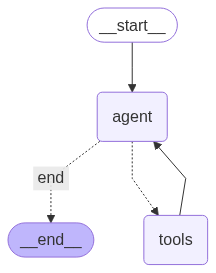

In [308]:
from IPython.display import Image, display

try:
    display(Image(agent_graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## Example Conversations

In [309]:
import uuid

user_questions = [
    "Hello",
    #  Before Renting - Vehicle Search & Comparison
    "Which cars are automatic and seat at least 5 people?",

    # Before Renting - Availability & Booking
    "Is the Mahindra Scorpio available this weekend?",

    # During Renting - Issues
    "The vehicle is making noise, what should I do?",

    "I want a stylish vehicle for a short city visit."
]

for question in user_questions:
    config = {"configurable": {"thread_id": str(uuid.uuid4())}}
    agent_graph.update_state(config, {"messages": []})
    for step in agent_graph.stream(
       {"messages":[HumanMessage(content=question)]},
        config,
        stream_mode="values",
    ):
        print(f"📝 Current messages count: {len(step['messages'])}")
        step["messages"][-1].pretty_print()
        print("-" * 30)
    agent_graph.update_state(config, {"messages": []})

    
    

📝 Current messages count: 1
================================ Human Message =================================

Hello
------------------------------
 Thinking...
✅ Tools available - using normal prompt
🤖 AGENT RESPONSE: ...
🔧 Tool call detected! Incrementing count to: 1
🔧 ROUTING: Going to tools
📝 Current messages count: 2
================================== Ai Message ==================================
Tool Calls:
  lookup_recommendations (0)
 Call ID: 0
  Args:
    query: affordable car options
------------------------------
📝 Current messages count: 3
================================= Tool Message =================================
Name: lookup_recommendations

Recommend vehicles with better comfort, mileage,
------------------------------
 Thinking...
✅ Tools available - using normal prompt


HfHubHTTPError: 422 Client Error: Unprocessable Entity for url: https://router.huggingface.co/hf-inference/models/mistralai/Mixtral-8x7B-Instruct-v0.1/v1/chat/completions (Request ID: Root=1-6849ea3c-43483dbe77e0b17d7dc20486;8ac04aa7-ed7c-41cf-a6c8-f7adb8a33a45)

Template error: syntax error: After the optional system message, conversation roles must alternate user/assistant/user/assistant/... (in <string>:11)
{"error":"Template error: syntax error: After the optional system message, conversation roles must alternate user/assistant/user/assistant/... (in <string>:11)","error_type":"template_error"}
